# Basic Image Classification

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Image Preprocessing

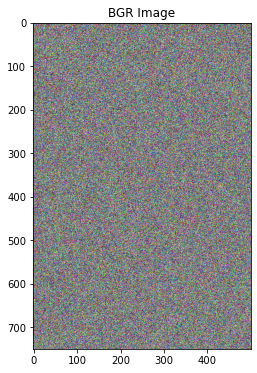

In [2]:
bird = np.random.rand(750,500,3) #Simulated IMAGE
bird_BGR = bird[:, :, (2, 1, 0)] #How to change the order of 1 dimension in matrices

plt.figure (figsize = (6, 6))
plt.title("BGR Image")
plt.imshow(bird_BGR)

In [3]:
with open('./datasets/cifar-10-batches-py/data_batch_1', 'rb') as input_file: 
    X = pickle.load(input_file, encoding='latin1')


In [4]:
# Managing multiple dimension data
X.keys()

X = X['data']
print(X.shape)

(10000, 3072)


In [5]:
X = X.reshape((-1,3,32,32))
print(X.shape)

X = X.transpose(0, 2, 3, 1)
print(X.shape)

X = X.reshape(-1, 3 * 32 * 32) 
print(X.shape)


(10000, 3, 32, 32)
(10000, 32, 32, 3)
(10000, 3072)


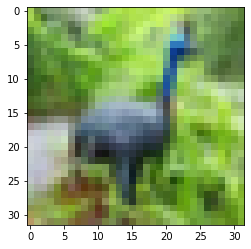

In [6]:
plt.imshow(X[6].reshape(32, 32, 3))

plt.show()

### Whitening

In [7]:
X = X - X.mean(axis=0)
X = X / np.std(X,axis=0)

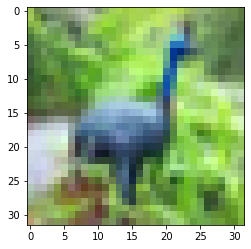

In [8]:
def show(i):
    i = i.reshape((32, 32, 3))

    m, M = i.min(), i.max()
    
    plt.imshow((i - m) / (M - m))
    plt.show()

show(X[6])

In [ ]:
X_subset = X[:100]
cov = np.cov(X_subset, rowvar=True) 
print(cov.shape)

U, S, V = np.linalg.svd(cov)     
print(U.shape)
print(S.shape)
print(V.shape)

epsilon = 1e-5

zca_matrix = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T))

print(zca_matrix.shape)

zca = np.dot(zca_matrix, X_subset)   
print(zca.shape)

show(zca[6])

# Preprocessing in Pytorch

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
# Pytorch preprocessing "pipeline" uses .Compose workflow
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', download=True, transform=transform)


Files already downloaded and verified


In [11]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets/cifar10/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [12]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16,
                                         shuffle=True, 
                                         num_workers=2)

In [26]:
# Get lists from dataloader with iterable (could be used in general)
images_batch, labels_batch = iter(dataloader).next()
print(images_batch.shape, labels_batch.shape)
print(labels_batch)

torch.Size([16, 3, 256, 256]) torch.Size([16])
tensor([2, 2, 6, 7, 5, 7, 5, 9, 2, 1, 1, 2, 7, 8, 3, 1])


In [29]:
# make a grid of images in batch
img = torchvision.utils.make_grid(images_batch)
print(img.shape)
img =  np.transpose(img,(1,2,0))
print(img.shape)

torch.Size([3, 518, 2066])
torch.Size([518, 2066, 3])


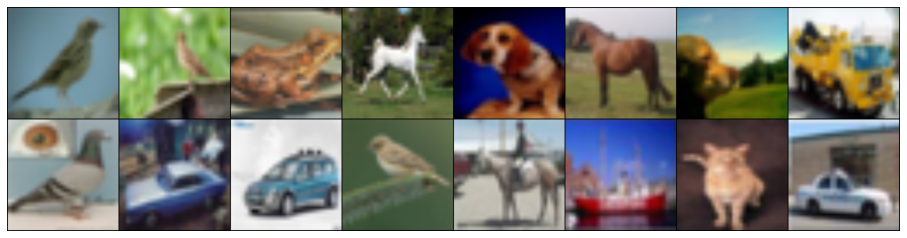

In [30]:
plt.figure (figsize = (16, 12))

plt.imshow(img)
plt.axis('off')
plt.show()

## Normalization

In [33]:
pop_mean = []
pop_std = []

for i, data in enumerate(dataloader, 0):
    
    # shape (batch_size, 3, height, width)
    numpy_image = data[0].numpy() 
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)
    
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)

print(pop_mean.shape, pop_std.shape)

(3125, 3) (3125, 3)


In [36]:
# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)

pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)

print(pop_mean)
print(pop_std)

[0.49159124 0.4823456  0.44671956]
[0.23829234 0.23476678 0.2525041 ]


## Applying Transforms

In [37]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(pop_mean, 
                                 pop_std)
            ])

trainset = torchvision.datasets.CIFAR10(root='./datasets/cifar10/train', train=True,
                                        download=True, transform=transform)



Files already downloaded and verified


In [38]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

images_batch, labels_batch = iter(trainloader).next()

images_batch.shape


torch.Size([16, 3, 224, 224])

## View Images

In [39]:
img = torchvision.utils.make_grid(images_batch)
img = np.transpose(img, (1, 2, 0))
m, M = img.min(), img.max()

# Ensure floating point image RGB values must be in the 0..1 range.

img = (1/(abs(m) * M)) * img + 0.5 

print(img)

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         ...,
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.5783, 0.4009, 0.4730],
         ...,
         [0.4336, 0.4559, 0.4320],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        ...,

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.1984, 0.1732, 0.2033],
         ...,
         [0.4010, 0.2466, 0.1452],
         [0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000],
         [0.

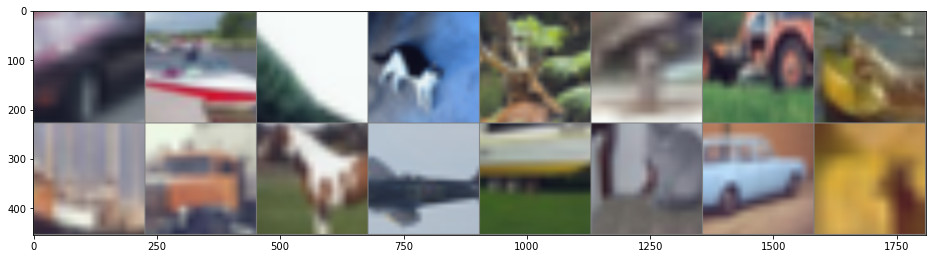

In [40]:
plt.figure (figsize = (16, 12))

plt.imshow(img)
plt.show()